In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
pwd

'/Users/song/Documents/Machine Learning Practical'

In [3]:
VGG_MEAN=[103.939,116.779,123.68]

# Load pretrained parameters, and build the VGG16 model

In [4]:
class vgg16():
    def __init__(self,vgg16_path = None):
        if vgg16_path is None:
            vgg16_path = os.path.join(os.getcwd(),'./VGG/vgg16.npy')
            self.data_dict = np.load(vgg16_path,encoding = 'latin1',allow_pickle=True).item()
            
    def forward(self,images):
        print('build model started')
        start_time = time.time()
        rgb_scaled = images * 255.0
        red, green, blue = tf.split(rgb_scaled,3,3)
        bgr = tf.concat([blue - VGG_MEAN[0],green-VGG_MEAN[1],blue-VGG_MEAN[2]],3)
        
        self.conv1_1 = self.conv_layer(bgr,'conv1_1')
        self.conv1_2 = self.conv_layer(self.conv1_1,'conv1_2')
        self.pool1 = self.max_pool_2x2(self.conv1_2,'pool1')
        
        self.conv2_1 = self.conv_layer(self.pool1,'conv2_1')
        self.conv2_2 = self.conv_layer(self.conv2_1,'conv2_2')
        self.pool2=self.max_pool_2x2(self.conv2_2,'pool2')
        
        self.conv3_1 = self.conv_layer(self.pool2,'conv3_1')
        self.conv3_2 = self.conv_layer(self.conv3_1,'conv3_2')
        self.conv3_3 = self.conv_layer(self.conv3_2,'conv3_3')
        self.pool3 = self.max_pool_2x2(self.conv3_3,'pool3')

        self.conv4_1 = self.conv_layer(self.pool3,'conv4_1')
        self.cov4_2 = self.conv_layer(self.conv4_1,'conv4_2')
        self.conv4_3 = self.conv_layer(self.cov4_2,'conv4_3')
        self.pool4 = self.max_pool_2x2(self.conv4_3,'pool4')
        
        self.conv5_1 = self.conv_layer(self.pool4,'conv5_1')
        self.cov5_2 = self.conv_layer(self.conv5_1,'conv5_2')
        self.conv5_3 = self.conv_layer(self.cov5_2,'conv5_3')
        self.pool5 = self.max_pool_2x2(self.conv5_3,'pool5')
        
        self.fc6 = self.fc_layer(self.pool5,'fc6')
        self.relu6 = tf.nn.relu(self.fc6)
        
        self.fc7 = self.fc_layer(self.relu6,'fc7')
        self.relu7 = tf.nn.relu(self.fc7)
        
        self.fc8 = self.fc_layer(self.relu7,'fc8')
        self.prob = tf.nn.softmax(self.fc8,name = 'prob')
        
        end_time = time.time()
        print('time consuming: %f'%(end_time -start_time ))
        
    def conv_layer(self,x,name):
        with tf.variable_scope(name):
            w = self.get_conv_filter(name)
            conv = tf.nn.conv2d(x,w,[1,1,1,1],padding='SAME')
            conv_biases = self.get_bias(name)
            result = tf.nn.relu(tf.nn.bias_add(conv,conv_biases))
            return result
                                 
    def get_conv_filter(self,name):
        return tf.constant(self.data_dict[name][0],name='filter')
                                
    def get_bias(self,name):
        return tf.constant(self.data_dict[name][1],name = 'biases')
                                 
    def max_pool_2x2(self,x,name):
        return tf.nn.max_pool(x,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'SAME',name = name)
                                 
    def fc_layer(self,x,name):
        with tf.variable_scope(name):
            shape = x.get_shape().as_list()
            dim =1
            for i in shape[1:]:
                dim *= i
            x = tf.reshape(x,[-1,dim])
            w = self.get_fc_weight(name)
            b = self.get_bias(name)
            result = tf.nn.bias_add(tf.matmul(x,w),b)
            return result
    
                                 
    def get_fc_weight(self,name):
            return tf.constant(self.data_dict[name][0],name = 'weights')
                                         

In [5]:
vgg = vgg16()


In [6]:
vgg.data_dict;

In [7]:
vgg.data_dict['fc6'][0].shape

(25088, 4096)

# Application Program

In [8]:
import skimage
from skimage import io, transform

In [9]:
def load_image(path):
    fig = plt.figure('Center and Resize')
    img = io.imread(path)
    img = img/255.0
    
    ax0 = fig.add_subplot(1,3,1)
    ax0.set_xlabel('Original Picture')
    ax0.imshow(img)
    
    short_edge = min(img.shape[:2])
    y = int((img.shape[0]-short_edge)/2)
    x = int((img.shape[1]-short_edge)/2)
    crop_img = img[y:y+short_edge, x: x+short_edge]
    
    ax1 = fig.add_subplot(1,3,2)
    ax1.set_xlabel('Center Picture')
    ax1.imshow(crop_img)
    
    re_img = transform.resize(crop_img,(224,224))
    
    ax2 = fig.add_subplot(1,3,3)
    ax2.set_xlabel('Resize Picture')
    ax2.imshow(re_img)
    
    img_ready = re_img.reshape((1,224,224,3))
    return img_ready
    

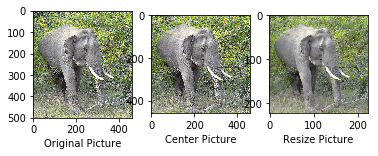

In [10]:
img_path = "./VGG/pic/c.jpg"
img_ready = load_image(img_path)

In [11]:
img_ready.shape

(1, 224, 224, 3)

In [12]:
with tf.Session() as sess:
    images = tf.placeholder(tf.float32, [1,224,224,3])
    vgg = vgg16()
    vgg.forward(images)
    #sess.run(vgg.prob,feed_dict = {images:img_ready})
    probability = sess.run(vgg.prob,feed_dict = {images:img_ready})
    top5 = np.argsort(probability[0])[-1:-6:-1]
    print('top5:',top5)

build model started
time consuming: 4.178511
top5: [101 385 386  51 346]


## labels[101] is Elephant! 